## 1. Packages Import

In [0]:
import pandas as pd
import numpy as np
import os
import json
import tempfile
import datetime
import re, string, unicodedata
import nltk
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk import SnowballStemmer
from nltk.stem import LancasterStemmer, WordNetLemmatizer
import matplotlib.pyplot as pl

import pickle
import matplotlib.pyplot as plt
import itertools
from functools import partial
from itertools import product

from sklearn import metrics
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow import keras
from keras import backend as K
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential, Model
from keras.models import model_from_json
from keras.layers import Dense, Input, Flatten, Embedding, Conv1D, SpatialDropout1D, MaxPooling1D, Dropout, Reshape, LSTM, CuDNNLSTM
from keras.layers import GlobalAveragePooling1D
from keras.layers.merge import Concatenate
from keras.utils import to_categorical
from keras.optimizers import Adam, RMSprop
from keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping
from keras.models import load_model

## 2. Data Loading
- Load and read the data in google cloud 
- Link is the sharable link in google drive

In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
def read_csv(uploaded, name):
  from io import StringIO
  s=str(uploaded[name],'utf-8')
  data = StringIO(s) 
  df=pd.read_csv(data)
  return df

In [4]:
## reviews data
link = "https://drive.google.com/open?id=1cXu9-KprFIUmPsFWT1TRR3UTc-6A07MI"
_, drive_id = link.split('=')
downloaded = drive.CreateFile({'id': drive_id})
downloaded.GetContentFile('./sample.csv')
reviews = pd.read_csv('./sample.csv')
print(len(reviews))
reviews.head()

1151350


,user_id,business_id,rating,date,reviews,useful,funny,cool
0,jlu4CztcSxrKx56ba1a5AQ,3fw2X5bZYeW9xCz_zGhOHg,3.0,2016-05-07 01:21:02,Tracy dessert had a big name in Hong Kong and ...,5.0,4.0,5.0
1,5JVY32_bmTBfIGpCCsnAfw,Mem13A3C202RzT53npn4NA,5.0,2017-05-13 10:41:43,If you are looking for the best pierogies in P...,9.0,6.0,9.0
2,3CJUJILq7CLHk_9OrvpvQg,I4Nr-MVc26qWr08-S3Q1ow,4.0,2016-01-17 05:26:22,The food is always good and the prices are rea...,0.0,0.0,0.0
3,jAVtSgE5L-Dt6_I5FIiVGA,EIL41z-hvVCeYHqfA9PyWQ,5.0,2017-09-20 15:23:35,Flat out fantastic! Have been here twice and ...,1.0,0.0,1.0
4,XPZVfP7DQCSL3Nb9t2vxsA,1HD5iUUfVJDbfEBIn9yVhw,5.0,2017-03-15 02:02:13,Yes... the Boba Tea explosion is in full force...,11.0,8.0,11.0


In [0]:
sample = reviews.iloc[:,:3]
sample.columns = ['UserId', 'ItemId', 'Rating']

In [7]:
## business side info data after doing MCA
link = "https://drive.google.com/open?id=1-RfRHys9E9_yM1GgYVkgNhCEzHwZY4yn"
_, drive_id = link.split('=')
downloaded = drive.CreateFile({'id': drive_id})
downloaded.GetContentFile('./mca_360.csv')
mca_360 = pd.read_csv('./mca_360.csv', index_col = 0)
print(len(mca_360))
mca_360.head()

158525


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359
0,0.390209,-0.141874,-0.024787,0.007635,0.004479,0.005321,-0.001719,0.008979,-0.042039,0.011388,-0.008475,-0.004595,0.054801,-0.047002,0.073899,0.052382,-0.023466,-0.005285,-0.016470,0.032010,-0.041693,0.051536,0.024262,-0.036784,-0.046240,-0.085344,-0.037467,-0.005590,-0.034093,0.446101,0.093440,0.027238,-0.085142,0.124344,0.021989,0.119862,0.047574,-0.007256,0.068440,0.131579,...,0.012354,-0.064545,-0.035728,-0.026217,0.023803,-0.027027,0.049357,-0.032810,0.060392,0.100077,-0.009260,0.009705,-0.040189,-0.051617,-0.047153,0.028062,-0.089909,-0.058069,0.018103,-0.029719,-0.062024,0.073288,-0.039176,-0.042305,-0.003148,-0.042952,0.013283,-0.006312,0.126536,0.021150,-0.037896,-0.006446,0.037206,0.013955,-0.008220,0.009126,0.029007,0.020773,-0.060387,0.023551
1,0.365826,-0.148637,-0.022868,0.032417,-0.010428,0.002482,-0.023108,-0.014044,0.033816,-0.004289,0.022969,0.002403,-0.055157,0.033370,-0.036803,-0.035206,0.001171,0.004552,0.015057,0.037899,-0.004622,0.052764,0.068709,-0.051641,-0.058654,-0.085231,-0.031868,0.017418,-0.048739,0.173780,0.002981,-0.008962,0.028198,-0.029671,-0.012633,-0.067508,-0.034395,-0.098755,-0.017086,0.061185,...,-0.084161,0.010988,-0.026525,-0.086515,0.032248,0.046716,-0.040699,0.028237,-0.008533,-0.115477,0.055384,-0.052946,0.014120,0.085491,0.012084,-0.083855,-0.050901,0.057905,-0.018244,-0.126595,0.017407,0.035584,0.053006,0.046946,-0.042200,0.041932,0.019395,0.026744,0.017574,0.078231,-0.034905,0.042729,0.053586,0.034828,0.073895,-0.026205,-0.050432,0.015082,0.025763,0.001025
2,-0.127132,0.021736,-0.048277,0.075905,0.027286,-0.001225,0.025816,0.025224,-0.029088,-0.022870,-0.037241,-0.006314,0.008574,0.213909,0.168525,-0.028078,0.009326,-0.012057,0.021457,0.070231,0.034884,0.021125,0.026477,0.029196,0.026330,0.019417,-0.040444,-0.005671,0.015438,0.002300,0.000950,0.002590,-0.005033,0.002974,0.008619,-0.001364,0.001108,0.001350,-0.008158,-0.004919,...,-0.001897,0.000538,0.001025,0.002179,-0.003979,0.001889,-0.002136,-0.004274,0.001529,0.000549,0.003023,0.005017,-0.001694,0.002988,-0.002172,0.001549,-0.002018,0.002554,-0.000341,-0.000043,-0.002310,-0.000023,0.002718,0.000619,0.000338,-0.004874,-0.001340,0.000259,-0.000102,-0.002121,0.001930,-0.002658,0.000339,0.005223,-0.004223,0.000826,-0.001772,0.002247,-0.000534,-0.004288
3,-0.144806,0.029597,-0.032426,0.015887,0.086019,-0.064911,-0.125189,-0.147328,0.122635,-0.022022,0.074733,-0.074694,0.022509,-0.032582,0.000943,0.002068,-0.008207,-0.012602,-0.012533,0.067021,0.011682,0.005412,0.015926,0.002032,0.011645,0.016392,-0.007682,0.045798,-0.024560,-0.000710,-0.098163,0.004946,-0.016975,0.108245,0.161834,-0.002254,-0.176515,0.006639,-0.032498,0.024061,...,-0.006519,0.013372,-0.014218,0.020215,0.014269,0.006045,-0.004250,0.005658,0.012949,-0.006342,-0.001821,-0.002253,-0.002970,-0.011111,0.010895,0.002854,0.005779,0.002055,-0.019074,-0.003954,0.009521,-0.011939,-0.008013,-0.004535,0.000816,0.016276,-0.000720,0.001426,-0.004185,-0.007289,0.001272,0.003318,-0.002825,0.012825,0.004479,0.011278,-0.003393,-0.001234,-0.004552,-0.000610
4,-0.087801,0.003856,-0.007513,-0.028747,0.076504,0.005780,-0.013603,-0.028622,0.016902,0.006161,-0.027791,0.253253,-0.027128,-0.001032,-0.000744,-0.008949,-0.092975,0.234718,-0.233315,0.043364,-0.075763,-0.116206,0.101695,0.045197,0.028566,0.088962,-0.036065,0.057783,-0.230328,0.012981,-0.013114,0.067557,0.081993,0.080268,-0.130877,-0.004499,-0.025730,-0.002891,0.025831,-0.031779,...,0.014025,0.019449,-0.015331,-0.023172,0.009752,0.004508,-0.012100,-0.029339,0.006943,0.003473,-0.008505,0.015146,0.016387,0.006383,-0.025890,-0.015626,0.016185,0.010445,0.002574,0.012362,0.028710,-0.006096,0.001278,0.004520,0.015261,0.029853,-0.000347,0.014407,0.013042,0.012714,0

In [8]:
## Complete business side info data
link = "https://drive.google.com/open?id=1UacX5fkE-p3pLC9rdzow-74JIkmXA6Yn"
_, drive_id = link.split('=')
downloaded = drive.CreateFile({'id': drive_id})
downloaded.GetContentFile('./bus_sideinfo.csv')
bus = pd.read_csv('./bus_sideinfo.csv', index_col = 0)
bus.head()

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (68) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,business_id,stars,review_count,Alcohol(beer_and_wine),WheelchairAccessible,Ambience(classy),WiFi(free),Music(jukebox),BikeParking,BusinessParking(garage),BusinessParking(validated),NoiseLevel(quiet),NoiseLevel(very_loud),GoodForMeal(breakfast),DietaryRestrictions(halal),Music(background_music),DietaryRestrictions(gluten-free),HairSpecializesIn(africanamerican),Caters,NoiseLevel(None),HairSpecializesIn(coloring),HairSpecializesIn(perms),RestaurantsGoodForGroups,GoodForMeal(dinner),RestaurantsTakeOut,DietaryRestrictions(vegan),Music(video),Ambience(trendy),HairSpecializesIn(straightperms),RestaurantsCounterService,BusinessAcceptsCreditCards,RestaurantsTableService,OutdoorSeating,HairSpecializesIn(kids),DietaryRestrictions(dairy-free),Ambience(upscale),GoodForMeal(lunch),GoodForMeal(brunch),NoiseLevel(average),Ambience(casual),...,Performing Arts,Arts & Entertainment,Building Supplies,Cafes,Signmaking,Sports Medicine,Bakeries,Local Fish Stores,Australian,Junk Removal & Hauling,Wine Tasting Classes,Horse Equipment Shops,Leather Goods,Computers,Event Planning & Services,Sandwiches,Pet Training,Environmental Abatement,Batting Cages,Vintage & Consignment,Audiologist,Visitor Centers,Telecommunications,Bail Bondsmen,Aerial Tours,Hindu Temples,Gutter Services,Apartments,Apartment Agents,Emergency Rooms,Swiss Food,Landscape Architects,Cheese Shops,Karate,Gas Stations,Gastropubs,Home & Rental Insurance,Candle Stores,Safe Stores,American (New)
0,QXAEGFB4oINsVuTFxEYKFQ,2.5,128,0,0,1,0,0,1,1,1,0,0,1,0,0,0,0,1,0,0,0,1,1,1,0,0,1,0,0,0,1,1,0,0,1,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,gnKjwL_1w79qoiV3IC_xQQ,4.0,170,1,0,1,0,0,1,1,1,0,0,1,0,0,0,0,1,0,0,0,1,1,1,0,0,1,0,0,1,1,1,0,0,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,xvX2CttrVhyG2z1dFg_0xw,5.0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,HhyxOkGAM07SRYtlQ4wMFQ,4.0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,68dUKd8_8liJ7in4aWOSEA,2.5,3,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [52]:
mca_360['ItemId']= bus['business_id']
mca_360.head()


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,ItemId
0,0.390209,-0.141874,-0.024787,0.007635,0.004479,0.005321,-0.001719,0.008979,-0.042039,0.011388,-0.008475,-0.004595,0.054801,-0.047002,0.073899,0.052382,-0.023466,-0.005285,-0.016470,0.032010,-0.041693,0.051536,0.024262,-0.036784,-0.046240,-0.085344,-0.037467,-0.005590,-0.034093,0.446101,0.093440,0.027238,-0.085142,0.124344,0.021989,0.119862,0.047574,-0.007256,0.068440,0.131579,...,-0.064545,-0.035728,-0.026217,0.023803,-0.027027,0.049357,-0.032810,0.060392,0.100077,-0.009260,0.009705,-0.040189,-0.051617,-0.047153,0.028062,-0.089909,-0.058069,0.018103,-0.029719,-0.062024,0.073288,-0.039176,-0.042305,-0.003148,-0.042952,0.013283,-0.006312,0.126536,0.021150,-0.037896,-0.006446,0.037206,0.013955,-0.008220,0.009126,0.029007,0.020773,-0.060387,0.023551,QXAEGFB4oINsVuTFxEYKFQ
1,0.365826,-0.148637,-0.022868,0.032417,-0.010428,0.002482,-0.023108,-0.014044,0.033816,-0.004289,0.022969,0.002403,-0.055157,0.033370,-0.036803,-0.035206,0.001171,0.004552,0.015057,0.037899,-0.004622,0.052764,0.068709,-0.051641,-0.058654,-0.085231,-0.031868,0.017418,-0.048739,0.173780,0.002981,-0.008962,0.028198,-0.029671,-0.012633,-0.067508,-0.034395,-0.098755,-0.017086,0.061185,...,0.010988,-0.026525,-0.086515,0.032248,0.046716,-0.040699,0.028237,-0.008533,-0.115477,0.055384,-0.052946,0.014120,0.085491,0.012084,-0.083855,-0.050901,0.057905,-0.018244,-0.126595,0.017407,0.035584,0.053006,0.046946,-0.042200,0.041932,0.019395,0.026744,0.017574,0.078231,-0.034905,0.042729,0.053586,0.034828,0.073895,-0.026205,-0.050432,0.015082,0.025763,0.001025,gnKjwL_1w79qoiV3IC_xQQ
2,-0.127132,0.021736,-0.048277,0.075905,0.027286,-0.001225,0.025816,0.025224,-0.029088,-0.022870,-0.037241,-0.006314,0.008574,0.213909,0.168525,-0.028078,0.009326,-0.012057,0.021457,0.070231,0.034884,0.021125,0.026477,0.029196,0.026330,0.019417,-0.040444,-0.005671,0.015438,0.002300,0.000950,0.002590,-0.005033,0.002974,0.008619,-0.001364,0.001108,0.001350,-0.008158,-0.004919,...,0.000538,0.001025,0.002179,-0.003979,0.001889,-0.002136,-0.004274,0.001529,0.000549,0.003023,0.005017,-0.001694,0.002988,-0.002172,0.001549,-0.002018,0.002554,-0.000341,-0.000043,-0.002310,-0.000023,0.002718,0.000619,0.000338,-0.004874,-0.001340,0.000259,-0.000102,-0.002121,0.001930,-0.002658,0.000339,0.005223,-0.004223,0.000826,-0.001772,0.002247,-0.000534,-0.004288,xvX2CttrVhyG2z1dFg_0xw
3,-0.144806,0.029597,-0.032426,0.015887,0.086019,-0.064911,-0.125189,-0.147328,0.122635,-0.022022,0.074733,-0.074694,0.022509,-0.032582,0.000943,0.002068,-0.008207,-0.012602,-0.012533,0.067021,0.011682,0.005412,0.015926,0.002032,0.011645,0.016392,-0.007682,0.045798,-0.024560,-0.000710,-0.098163,0.004946,-0.016975,0.108245,0.161834,-0.002254,-0.176515,0.006639,-0.032498,0.024061,...,0.013372,-0.014218,0.020215,0.014269,0.006045,-0.004250,0.005658,0.012949,-0.006342,-0.001821,-0.002253,-0.002970,-0.011111,0.010895,0.002854,0.005779,0.002055,-0.019074,-0.003954,0.009521,-0.011939,-0.008013,-0.004535,0.000816,0.016276,-0.000720,0.001426,-0.004185,-0.007289,0.001272,0.003318,-0.002825,0.012825,0.004479,0.011278,-0.003393,-0.001234,-0.004552,-0.000610,HhyxOkGAM07SRYtlQ4wMFQ
4,-0.087801,0.003856,-0.007513,-0.028747,0.076504,0.005780,-0.013603,-0.028622,0.016902,0.006161,-0.027791,0.253253,-0.027128,-0.001032,-0.000744,-0.008949,-0.092975,0.234718,-0.233315,0.043364,-0.075763,-0.116206,0.101695,0.045197,0.028566,0.088962,-0.036065,0.057783,-0.230328,0.012981,-0.013114,0.067557,0.081993,0.080268,-0.130877,-0.004499,-0.025730,-0.002891,0.025831,-0.031779,...,0.019449,-0.015331,-0.023172,0.009752,0.004508,-0.012100,-0.029339,0.006943,0.003473,-0.008505,0.015146,0.016387,0.006383,-0.025890,-0.015626,0.016185,0.010445,0.002574,0.012362,0.028710,-0.006096,0.001278,0.004520,0.015261,

In [0]:
item_side_info = mca_360

## 3. Data Processing

### 3.1 reviews data train-test split

In [12]:
np.random.seed(1)
user_ids = sample.UserId.drop_duplicates().values
item_ids = sample.ItemId.drop_duplicates().values
users_train = set(np.random.choice(user_ids, size=int(user_ids.shape[0] * .75), replace=False))
items_train = set(np.random.choice(item_ids, size=int(item_ids.shape[0] * .75), replace=False))
train = sample.loc[sample.UserId.isin(users_train) & sample.ItemId.isin(items_train)].reset_index(drop=True)

np.random.seed(1)
train_ix = train.sample(frac=.85).index
test_ix = np.setdiff1d(train.index.values, train_ix)
test_warm_start = train.loc[test_ix].reset_index(drop=True)
train = train.loc[train_ix].reset_index(drop=True)
users_train = set(train.UserId)
items_train = set(train.ItemId)
test_warm_start = test_warm_start.loc[test_warm_start.UserId.isin(users_train) &
                                      test_warm_start.ItemId.isin(items_train)].reset_index(drop=True)

test_cold_start = sample.loc[~sample.UserId.isin(users_train) & ~sample.ItemId.isin(items_train)].reset_index(drop=True)
test_new_items = sample.loc[(sample.UserId.isin(users_train)) & (~sample.ItemId.isin(items_train))].reset_index(drop=True)
test_new_items_set = set(test_new_items.ItemId)

print(train.shape)
print(test_warm_start.shape)
print(test_new_items.shape)


(551836, 3)
(92936, 3)
(219959, 3)


In [0]:
len(train['ItemId'].unique())

76469

In [0]:

print(len(users_train))
print(len(items_train))

47345
76469


### 3.2 business side info processing

In [13]:
items_w_sideinfo = set(item_side_info.ItemId)
test_new_items = test_new_items.loc[test_new_items.ItemId.isin(items_w_sideinfo)].reset_index(drop=True) #取有sideinfo 的子集

item_sideinfo_train = item_side_info.loc[item_side_info.ItemId.isin(items_train)].reset_index(drop=True) #取train的sideinfo
item_sideinfo_testnew = item_side_info.loc[item_side_info.ItemId.isin(test_new_items_set)].reset_index(drop=True) #取newbusiness 的sideinfo
test_cold_start = test_cold_start.loc[test_cold_start.ItemId.isin(items_w_sideinfo)].reset_index(drop=True) #取有sideinfo 的子集
print(len(test_new_items))
item_sideinfo_train.head()

219959


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,ItemId
0,0.365826,-0.148637,-0.022868,0.032417,-0.010428,0.002482,-0.023108,-0.014044,0.033816,-0.004289,0.022969,0.002403,-0.055157,0.033370,-0.036803,-0.035206,0.001171,0.004552,0.015057,0.037899,-0.004622,0.052764,0.068709,-0.051641,-0.058654,-0.085231,-0.031868,0.017418,-0.048739,0.173780,0.002981,-0.008962,0.028198,-0.029671,-0.012633,-0.067508,-0.034395,-0.098755,-0.017086,0.061185,...,0.010988,-0.026525,-0.086515,0.032248,0.046716,-0.040699,0.028237,-0.008533,-0.115477,0.055384,-0.052946,0.014120,0.085491,0.012084,-0.083855,-0.050901,0.057905,-0.018244,-0.126595,0.017407,0.035584,0.053006,0.046946,-0.042200,0.041932,0.019395,0.026744,0.017574,0.078231,-0.034905,0.042729,0.053586,0.034828,0.073895,-0.026205,-0.050432,0.015082,0.025763,0.001025,gnKjwL_1w79qoiV3IC_xQQ
1,-0.144806,0.029597,-0.032426,0.015887,0.086019,-0.064911,-0.125189,-0.147328,0.122635,-0.022022,0.074733,-0.074694,0.022509,-0.032582,0.000943,0.002068,-0.008207,-0.012602,-0.012533,0.067021,0.011682,0.005412,0.015926,0.002032,0.011645,0.016392,-0.007682,0.045798,-0.024560,-0.000710,-0.098163,0.004946,-0.016975,0.108245,0.161834,-0.002254,-0.176515,0.006639,-0.032498,0.024061,...,0.013372,-0.014218,0.020215,0.014269,0.006045,-0.004250,0.005658,0.012949,-0.006342,-0.001821,-0.002253,-0.002970,-0.011111,0.010895,0.002854,0.005779,0.002055,-0.019074,-0.003954,0.009521,-0.011939,-0.008013,-0.004535,0.000816,0.016276,-0.000720,0.001426,-0.004185,-0.007289,0.001272,0.003318,-0.002825,0.012825,0.004479,0.011278,-0.003393,-0.001234,-0.004552,-0.000610,HhyxOkGAM07SRYtlQ4wMFQ
2,-0.089234,-0.008396,0.091358,-0.094743,-0.147362,0.040100,-0.028889,-0.036376,-0.046046,-0.120931,-0.000679,0.019656,-0.008192,0.011231,-0.024845,-0.046994,-0.001379,0.002522,-0.002922,0.008029,-0.001527,0.004540,-0.004653,-0.001758,0.001172,-0.000469,0.002816,-0.009892,0.012135,0.003996,-0.003584,0.071939,-0.003637,0.006675,-0.005674,-0.050145,0.009911,-0.001003,0.013945,-0.012062,...,-0.004154,0.002792,0.001104,-0.005717,0.003408,-0.005216,-0.000387,0.001515,0.001225,-0.000854,-0.002672,0.008477,0.003588,0.005790,-0.007968,-0.009057,0.007785,0.006550,-0.003698,0.006830,0.001775,0.008674,0.010689,-0.004831,0.000738,0.011814,0.001584,0.001192,-0.011986,-0.002671,0.004740,-0.003588,-0.004939,0.004959,-0.000239,-0.003941,-0.010642,0.009322,0.001475,4GBVPIYRvzGh4K4TkRQ_rw
3,-0.099661,-0.002004,0.005897,-0.087168,0.132571,0.031446,-0.108945,-0.079711,0.106826,0.005364,0.015247,0.411043,-0.103638,-0.076830,0.100792,0.024319,0.151166,-0.068870,0.100710,-0.007926,-0.071376,0.000933,-0.079303,0.003064,0.022908,0.012869,0.027066,-0.029259,0.143195,0.035685,0.003852,-0.024973,-0.050031,-0.097587,0.060636,-0.008261,0.017197,0.000991,-0.004580,0.023606,...,0.013089,-0.000546,0.013514,0.008383,0.014933,-0.010011,-0.013498,0.004728,0.003912,0.001593,-0.008253,-0.017776,-0.023094,-0.012524,-0.003013,-0.004989,0.012921,-0.005373,-0.011255,0.005567,-0.003587,0.012121,-0.003320,-0.000515,0.008351,0.000986,-0.016291,-0.005159,-0.010278,0.006803,-0.009073,0.006609,-0.008667,-0.004987,0.015534,-0.012924,0.017517,0.017818,-0.006306,fcXOEZdXYeZqnQ3lGlOXmg
4,0.250138,-0.120846,-0.028122,0.029315,-0.000652,-0.004820,-0.003387,0.000411,0.005978,0.001394,-0.003936,-0.000182,-0.017612,0.007631,-0.009037,-0.003238,-0.000902,-0.005203,-0.017302,-0.042685,0.042212,-0.083809,-0.069212,0.021683,0.067711,0.077933,0.038715,0.012831,0.060657,-0.079928,0.045655,0.012750,0.006482,0.046705,-0.032475,0.045978,-0.019629,-0.002011,0.059283,0.072527,...,-0.014908,-0.001405,0.020005,0.003847,-0.016747,-0.007688,-0.014412,-0.015747,0.003416,-0.001969,-0.003604,-0.002972,-0.001904,-0.009330,-0.001332,-0.003108,0.023212,-0.011402,0.005203,0.005473,0.002500,-0.005670,-0.0012

## 4. Models

### 4.1 Basic Collective Matrix Factorization Model - Only ratings

In [14]:
!pip install cmfrec

  Created wheel for cmfrec: filename=cmfrec-0.5.2.3-cp36-none-any.whl size=17648 sha256=cdf0a7e9e5a39e73d4c7c97de308a7626612887cfc9666737aa4ae0122fa3f88
  Stored in directory: /root/.cache/pip/wheels/38/25/60/7380da6f3874971edc38b1b7e11317bc40fd8e9d01028f7cee
Successfully built cmfrec


In [0]:
from copy import deepcopy
from cmfrec import CMF

In [22]:
%%time
#k=40, warm start
model_no_side_info = CMF(k=40, reg_param=1e-4, random_seed=1)
model_no_side_info.fit(deepcopy(train))
test_warm_start['Predicted'] = model_no_side_info.predict(test_warm_start.UserId, test_warm_start.ItemId)






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where




INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 1.589353
  Number of iterations: 355
  Number of functions evaluations: 406
CPU times: user 9min 39s, sys: 1min 40s, total: 11min 19s
Wall time: 7min 5s


In [0]:
RMSE_noside = []


In [82]:
RMSE_warm_k40 = np.sqrt(np.mean( (test_warm_start.Predicted - test_warm_start.Rating)**2))
RMSE_noside.append(RMSE_warm_k40)
print("RMSE (no side info, warm start), k=40: ",  RMSE_warm_k40)

RMSE (no side info, warm start), k=40:  1.2432588965211968


In [28]:
%%time
#k=50, warm start
model_no_side_info_50 = CMF(k=50, reg_param=1e-4, random_seed=1)
model_no_side_info_50.fit(deepcopy(train))
test_warm_start['Predicted_50'] = model_no_side_info_50.predict(test_warm_start.UserId, test_warm_start.ItemId)

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 1.589352
  Number of iterations: 270
  Number of functions evaluations: 308
CPU times: user 9min 26s, sys: 1min 24s, total: 10min 51s
Wall time: 6min 49s


In [83]:
RMSE_warm_k50 = np.sqrt(np.mean( (test_warm_start.Predicted_50 - test_warm_start.Rating)**2))
RMSE_noside.append(RMSE_warm_k50)
print("RMSE (no side info, warm start), k=50: ",  RMSE_warm_k50)

RMSE (no side info, warm start), k=50:  1.2432564523853906


In [34]:
%%time
#k=35, warm start
model_no_side_info_35 = CMF(k=35, reg_param=1e-4, random_seed=1)
model_no_side_info_35.fit(deepcopy(train))
test_warm_start['Predicted_35'] = model_no_side_info_35.predict(test_warm_start.UserId, test_warm_start.ItemId)

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 1.589353
  Number of iterations: 223
  Number of functions evaluations: 253
CPU times: user 4min 58s, sys: 57.7 s, total: 5min 55s
Wall time: 3min 39s


In [84]:
RMSE_warm_k35 = np.sqrt(np.mean( (test_warm_start.Predicted_35 - test_warm_start.Rating)**2))
RMSE_noside.append(RMSE_warm_k35)
print("RMSE (no side info, warm start), k=35: ",  RMSE_warm_k35)

RMSE (no side info, warm start), k=35:  1.243255704584303


In [86]:
RMSE_noside

[1.2432588965211968, 1.2432564523853906, 1.243255704584303]

In [30]:
avg_ratings = train.groupby('ItemId')['Rating'].mean().to_frame().rename(columns={"Rating" : "AvgRating"})
test_ = pd.merge(test_warm_start, avg_ratings, left_on='ItemId', right_index=True, how='left')

print('Averge business rating:', test_.groupby('UserId')['Rating'].mean().mean())
print('Average rating for top-10 rated by each user:', test_.sort_values(['UserId','Rating'], ascending=False).groupby('UserId')['Rating'].head(10).mean())
print('Average rating for bottom-10 rated by each user:', test_.sort_values(['UserId','Rating'], ascending=True).groupby('UserId')['Rating'].head(10).mean())
print('Average rating for top-10 recommendations of best-rated movies:', test_.sort_values(['UserId','AvgRating'], ascending=False).groupby('UserId')['Rating'].head(10).mean())
print('----------------------')
print('Average rating for top-10 recommendations from this model:', test_.sort_values(['UserId','Predicted'], ascending=False).groupby('UserId')['Rating'].head(10).mean())
print('Average rating for bottom-10 (non-)recommendations from this model:', test_.sort_values(['UserId','Predicted'], ascending=True).groupby('UserId')['Rating'].head(10).mean())

Averge business rating: 3.7347605507966
Average rating for top-10 rated by each user: 3.835473000548035
Average rating for bottom-10 rated by each user: 3.720922097456886
Average rating for top-10 recommendations of best-rated movies: 3.797448723778874
----------------------
Average rating for top-10 recommendations from this model: 3.796597521017712
Average rating for bottom-10 (non-)recommendations from this model: 3.7572789496391135


### 4.2 Model with business side info

In [31]:
# #warm, k=35, partial
# %%time
# model_item_info = CMF(k=35, k_main=15, k_item=10, reg_param=1e-3, w_main=10.0, w_item=0.5, random_seed=1)
# model_item_info.fit(deepcopy(train),
#                     item_info = deepcopy(item_sideinfo_train))
# test_warm_start['Predicted_itemside'] = model_item_info.predict(test_warm_start.UserId, test_warm_start.ItemId)

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 15.894648
  Number of iterations: 321
  Number of functions evaluations: 378
CPU times: user 15min 23s, sys: 2min 2s, total: 17min 25s
Wall time: 10min 25s


In [0]:
# RMSE_side = []

In [33]:

# RMSE_warm_side_k35 = np.sqrt(np.mean( (test_warm_start.Predicted_itemside - test_warm_start.Rating)**2))
# RMSE_side.append(RMSE_warm_side_k35)
# print("RMSE (side info, warm start), k=35: ",  RMSE_warm_side_k35)

RMSE (side info, warm start), k=35:  1.2432584992744733


In [0]:
# #k=40
# %%time
# model_item_info = CMF(k=35, k_main=15, k_item=10, reg_param=1e-3, w_main=10.0, w_item=0.5, random_seed=1)
# model_item_info.fit(deepcopy(train),
#                     item_info = deepcopy(item_sideinfo_train))
# test_warm_start['Predicted_itemside'] = model_item_info.predict(test_warm_start.UserId, test_warm_start.ItemId)

In [37]:
# len(item_side_info)

158525

In [39]:
# len(item_sideinfo_train)

76469

In [40]:
#k=35, all side info
%%time
model_item_info_all = CMF(k=35, k_main=15, k_item=10, reg_param=1e-3, w_main=10.0, w_item=0.5, random_seed=1)
model_item_info_all.fit(deepcopy(train), item_info = deepcopy(item_side_info))
test_warm_start['PredictedAll_35'] = model_item_info_all.predict(test_warm_start.UserId, test_warm_start.ItemId)
test_new_items['PredictedAll_35'] = model_item_info_all.predict(test_new_items.UserId, test_new_items.ItemId)

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 15.894464
  Number of iterations: 295
  Number of functions evaluations: 337
CPU times: user 22min 59s, sys: 2min 18s, total: 25min 17s
Wall time: 15min 38s


In [0]:
RMSE_sideall_warm = []
RMSE_sideall_newitem=[]

In [64]:

RMSE_sideall_warm_k35 = np.sqrt(np.mean( (test_warm_start.PredictedAll_35 - test_warm_start.Rating)**2))
RMSE_sideall_warm.append(RMSE_sideall_warm_k35)
print("RMSE (side info, warm start), k=35: ",  RMSE_warm_sideall_k35)

RMSE (side info, warm start), k=35:  1.2432576568745723


In [65]:

RMSE_sideall_newitem_k35 = np.sqrt(np.mean( (test_new_items.PredictedAll_35 - test_new_items.Rating)**2))
RMSE_sideall_newitem.append(RMSE_sideall_newitem_k35)
print("RMSE (side info, new item), k=35: ",  RMSE_sideall_newitem_k35)

RMSE (side info, new item), k=35:  1.3204707302384842


In [56]:
#k=40, all side info
%%time
model_item_info_all = CMF(k=40, k_main=15, k_item=10, reg_param=1e-3, w_main=10.0, w_item=0.5, random_seed=1)
model_item_info_all.fit(deepcopy(train), item_info = deepcopy(item_side_info))
test_warm_start['PredictedAll_40'] = model_item_info_all.predict(test_warm_start.UserId, test_warm_start.ItemId)
test_new_items['PredictedAll_40'] = model_item_info_all.predict(test_new_items.UserId, test_new_items.ItemId)

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 15.894461
  Number of iterations: 443
  Number of functions evaluations: 501
CPU times: user 35min 51s, sys: 3min 27s, total: 39min 18s
Wall time: 24min 27s


In [66]:
RMSE_sideall_warm_k40 = np.sqrt(np.mean( (test_warm_start.PredictedAll_40 - test_warm_start.Rating)**2))
RMSE_sideall_warm.append(RMSE_sideall_warm_k40)
print("RMSE (side info, warm start), k=40: ",  RMSE_sideall_warm_k40)

RMSE (side info, warm start), k=35:  1.2432579594102526


In [68]:
RMSE_sideall_newitem_k40 = np.sqrt(np.mean( (test_new_items.PredictedAll_40 - test_new_items.Rating)**2))
RMSE_sideall_newitem.append(RMSE_sideall_newitem_k40)
print("RMSE (side info, new item), k=40: ",  RMSE_sideall_newitem_k40)

RMSE (side info, new item), k=35:  1.3204706764683518


In [69]:
#k=50, all side info
%%time
model_item_info_all = CMF(k=50, k_main=15, k_item=10, reg_param=1e-3, w_main=10.0, w_item=0.5, random_seed=1)
model_item_info_all.fit(deepcopy(train), item_info = deepcopy(item_side_info))
test_warm_start['PredictedAll_50'] = model_item_info_all.predict(test_warm_start.UserId, test_warm_start.ItemId)
test_new_items['PredictedAll_50'] = model_item_info_all.predict(test_new_items.UserId, test_new_items.ItemId)

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 15.894460
  Number of iterations: 580
  Number of functions evaluations: 678
CPU times: user 54min 47s, sys: 5min 16s, total: 1h 4s
Wall time: 37min 26s


In [70]:
RMSE_sideall_warm_k50 = np.sqrt(np.mean( (test_warm_start.PredictedAll_50 - test_warm_start.Rating)**2))
RMSE_sideall_warm.append(RMSE_sideall_warm_k50)
print("RMSE (side info, warm start), k=50: ",  RMSE_sideall_warm_k50)

RMSE (side info, warm start), k=50:  1.2432576193021465


In [71]:
RMSE_sideall_newitem_k50 = np.sqrt(np.mean( (test_new_items.PredictedAll_50 - test_new_items.Rating)**2))
RMSE_sideall_newitem.append(RMSE_sideall_newitem_k50)
print("RMSE (side info, new item), k=50: ",  RMSE_sideall_newitem_k50)

RMSE (side info, new item), k=50:  1.3204711087663736


## 5. Parameters Tunning

In [91]:
K = [35, 40, 50]
print(RMSE_sideall_warm)
print(RMSE_sideall_newitem)
RMSE_noside = [RMSE_noside[2],RMSE_noside[0],RMSE_noside[1]]

print(RMSE_noside)

[1.2432576568745723, 1.2432579594102526, 1.2432576193021465]
[1.3204707302384842, 1.3204706764683518, 1.3204711087663736]
[1.243255704584303, 1.2432588965211968, 1.2432564523853906]


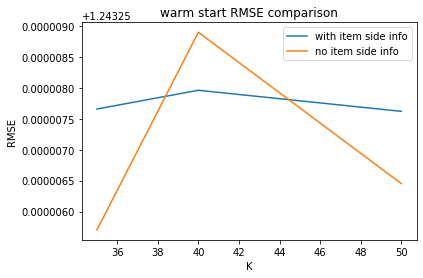

In [95]:
plt.plot(K, RMSE_sideall_warm, label ="with item side info")
plt.plot(K, RMSE_noside, label ="no item side info")
plt.xlabel('K')
plt.ylabel('RMSE')
plt.title('warm start RMSE comparison')
plt.legend()
plt.show()

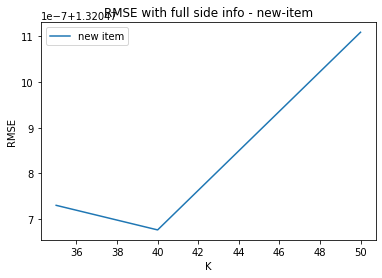

In [119]:
plt.plot(K, RMSE_sideall_newitem, label = "new item")
plt.xlabel('K')
plt.ylabel('RMSE')
plt.title('RMSE with full side info - new-item')
plt.legend()
plt.show()

In [0]:
# We choose K

In [0]:
%%time
model_item_info_diffweight = CMF(k=50, k_main=0, k_item=0, reg_param=1e-3, w_main=5.0, w_item=5.0, random_seed=1)
model_item_info_diffweight.fit(deepcopy(train), item_info = deepcopy(item_side_info))
test_warm_start['PredictedAll2'] = model_item_info_diffweight.predict(test_warm_start.UserId, test_warm_start.ItemId)
test_new_items['PredictedAll2'] = model_item_info_diffweight.predict(test_new_items.UserId, test_new_items.ItemId)

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 7.802636
  Number of iterations: 59
  Number of functions evaluations: 81
CPU times: user 3min 28s, sys: 28 s, total: 3min 56s
Wall time: 2min 31s


In [0]:
print("RMSE (item side info, warm start): ", np.sqrt(np.mean( (test_warm_start.Predicted - test_warm_start.Rating)**2) ))
print("RMSE (item side info, warm start, extra items): ", np.sqrt(np.mean( (test_warm_start.PredictedAll - test_warm_start.Rating)**2) ))
print("RMSE (item side info, warm start, extra items, diff. weighting): ", np.sqrt(np.mean( (test_warm_start.PredictedAll2 - test_warm_start.Rating)**2) ))
# print("RMSE (item side info, new items, added afterwards): ", np.sqrt(np.mean( (test_new_items.Predicted - test_new_items.Rating)**2) ))
print("RMSE (item side info, items trained without ratings): ", np.sqrt(np.mean( (test_new_items.PredictedAll - test_new_items.Rating)**2) ))
print("RMSE (item side info, items trained without ratings, diff. weighting): ", np.sqrt(np.mean( (test_new_items.PredictedAll2 - test_new_items.Rating)**2) ))

RMSE (item side info, warm start):  1.1926240476073016
RMSE (item side info, warm start, extra items):  1.1926199062473668
RMSE (item side info, warm start, extra items, diff. weighting):  1.2196178205851411
RMSE (item side info, items trained without ratings):  1.265022582687527
RMSE (item side info, items trained without ratings, diff. weighting):  1.277434897890229


In [0]:

avg_ratings = train.groupby('ItemId')['Rating'].mean().to_frame().rename(columns={"Rating" : "AvgRating"})
test_ = pd.merge(test_warm_start, avg_ratings, left_on='ItemId', right_index=True, how='left')

print('Averge movie rating:', test_.groupby('UserId')['Rating'].mean().mean())
print('Average rating for top-10 rated by each user:', test_.sort_values(['UserId','Rating'], ascending=False).groupby('UserId')['Rating'].head(10).mean())
print('Average rating for bottom-10 rated by each user:', test_.sort_values(['UserId','Rating'], ascending=True).groupby('UserId')['Rating'].head(10).mean())
print('Average rating for top-10 recommendations of best-rated movies:', test_.sort_values(['UserId','AvgRating'], ascending=False).groupby('UserId')['Rating'].head(10).mean())
print('----------------------')
print('Average rating for top-10 recommendations from this model:', test_.sort_values(['UserId','Predicted'], ascending=False).groupby('UserId')['Rating'].head(10).mean())
print('Average rating for bottom-10 (non-)recommendations from this model:', test_.sort_values(['UserId','Predicted'], ascending=True).groupby('UserId')['Rating'].head(10).mean())

Averge movie rating: 3.7725292469362843
Average rating for top-10 rated by each user: 3.877430854871937
Average rating for bottom-10 rated by each user: 3.735210320997034
Average rating for top-10 recommendations of best-rated movies: 3.829420101398244
----------------------
Average rating for top-10 recommendations from this model: 3.828806452084216
Average rating for bottom-10 (non-)recommendations from this model: 3.778706368803238


In [0]:

print('Average rating for top-10 recommendations (per user) from this model per configuration')
print('warm start: ', test_warm_start.sort_values(['UserId','Predicted'], ascending=False).groupby('UserId')['Rating'].head(10).mean())
print('warm start, extra items: ', test_warm_start.sort_values(['UserId','PredictedAll'], ascending=False).groupby('UserId')['Rating'].head(10).mean())
# print('new items, added afterwards: ', test_new_items.sort_values(['UserId','Predicted'], ascending=False).groupby('UserId')['Rating'].head(10).mean())
print('items trained without ratings: ', test_new_items.sort_values(['UserId','PredictedAll'], ascending=False).groupby('UserId')['Rating'].head(10).mean())
print('items trained without ratings, diff. weighting: ', test_new_items.sort_values(['UserId','PredictedAll2'], ascending=False).groupby('UserId')['Rating'].head(10).mean())

Average rating for top-10 recommendations (per user) from this model per configuration
warm start:  3.828806452084216
warm start, extra items:  3.828806452084216
items trained without ratings:  3.7918668297085625
items trained without ratings, diff. weighting:  3.7917649285235973


## 6. Prediction for users last reviews

In [15]:
#sample train reviews data
link = "https://drive.google.com/open?id=16YyX6o1AUr1VNYB1DXnybxqqfA8Q-u1n"
_, drive_id = link.split('=')
downloaded = drive.CreateFile({'id': drive_id})
downloaded.GetContentFile('./sample_train.csv')
sample_train = pd.read_csv('./sample_train.csv')
print(len(sample_train))
sample_train.head()

1088141


,user_id,business_id,rating,date,reviews,useful,funny,cool
0,jlu4CztcSxrKx56ba1a5AQ,3fw2X5bZYeW9xCz_zGhOHg,3.0,2016-05-07 01:21:02,Tracy dessert had a big name in Hong Kong and ...,5.0,4.0,5.0
1,5JVY32_bmTBfIGpCCsnAfw,Mem13A3C202RzT53npn4NA,5.0,2017-05-13 10:41:43,If you are looking for the best pierogies in P...,9.0,6.0,9.0
2,3CJUJILq7CLHk_9OrvpvQg,I4Nr-MVc26qWr08-S3Q1ow,4.0,2016-01-17 05:26:22,The food is always good and the prices are rea...,0.0,0.0,0.0
3,jAVtSgE5L-Dt6_I5FIiVGA,EIL41z-hvVCeYHqfA9PyWQ,5.0,2017-09-20 15:23:35,Flat out fantastic! Have been here twice and ...,1.0,0.0,1.0
4,XPZVfP7DQCSL3Nb9t2vxsA,1HD5iUUfVJDbfEBIn9yVhw,5.0,2017-03-15 02:02:13,Yes... the Boba Tea explosion is in full force...,11.0,8.0,11.0


In [16]:
#sample test reviews data
link = "https://drive.google.com/open?id=1P0p98XkIXW9QBVMDXFEiJMoaE8YsesWQ"
_, drive_id = link.split('=')
downloaded = drive.CreateFile({'id': drive_id})
downloaded.GetContentFile('./sample_test.csv')
sample_test = pd.read_csv('./sample_test.csv')
print(len(sample_test))
sample_test.head()

63208


,user_id,business_id,rating,date,reviews,useful,funny,cool
0,IZPYIYdr05FvjKva2986aw,a0v7Si0DK4cIko7AQY4YXg,5.0,2018-04-27 18:31:23,Go. Seriously. You will not be disappointed on...,2,0,1
1,08Tj4NyfKvI9D-VMcQrwpw,0qSKZhVC_BHPuKro4QGWJw,5.0,2018-05-08 17:57:59,Hank's definitely stays on my list of places t...,0,0,0
2,4M25m7sE45Q_hNOch4b8fA,w8t3l-8xomzWDWhad4E_AQ,5.0,2018-05-28 20:27:57,Mr Cool Heating and Air Conditioning came to t...,2,0,0
3,co-GuD549dZTJ6OiJS1Ttw,KWywu2tTEPWmR9JnBc0WyQ,5.0,2017-02-19 09:17:53,It's awesome here!!The guys are soooo hot and ...,0,0,1
4,W1CQf1GKX0JZMWhT1jlTaA,PNbX4mT6krRy_I0il8Il4Q,5.0,2017-04-07 21:13:18,I was skeptical about all these great reviews....,0,0,0


In [0]:
#Data processing
sample_train = sample_train.rename(columns = {'user_id': 'UserId', 'business_id': 'ItemId', 'rating':'Rating'})
sample_test = sample_test.rename(columns = {'user_id': 'UserId', 'business_id': 'ItemId', 'rating':'Rating'})
train_final = sample_train[['UserId', 'ItemId', 'Rating']].reset_index(drop=True)
test_final = sample_test[['UserId', 'ItemId', 'Rating']].reset_index(drop=True)

In [0]:
items_train_final = train_final.ItemId
items_test_final = test_final.ItemId
test_warm_start_final = test_final.loc[test_final.ItemId.isin(items_train_final)].reset_index(drop=True)
test_new_items_final = test_final.loc[~test_final.ItemId.isin(items_train_final)].reset_index(drop=True)

In [116]:
# RMSE_sideall_warm

[1.2432576568745723, 1.2432579594102526, 1.2432576193021465]

In [118]:
# RMSE_sideall = test_warm_ratio*np.array(RMSE_sideall_warm) + test_newitem_ration*np.array(RMSE_sideall_newitem)
# RMSE_sideall

array([1.24641298, 1.24641326, 1.24641295])

In [0]:
# K=40, full side info, for new Item
# K=50, full side info, for warm start

### 6.1 Make Prediction and Evaluate Result

In [23]:
#k=50, all side info, for warm start
%%time
model_item_info_all = CMF(k=50, k_main=15, k_item=10, reg_param=1e-3, w_main=10.0, w_item=0.5, random_seed=1)
model_item_info_all.fit(deepcopy(train_final), item_info = deepcopy(item_side_info))
test_warm_start_final['PredictedAll'] = model_item_info_all.predict(test_warm_start_final.UserId, test_warm_start_final.ItemId)

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 16.235182
  Number of iterations: 74
  Number of functions evaluations: 103
CPU times: user 18min 57s, sys: 23min, total: 41min 58s
Wall time: 3min 8s


In [24]:
RMSE_sideall_warm_final = np.sqrt(np.mean( (test_warm_start_final.PredictedAll - test_warm_start_final.Rating)**2))
MAE_sideall_warm_final = np.mean(np.abs(test_warm_start_final.PredictedAll - test_warm_start_final.Rating))

print("MAE (side info, warm start, final), k=50: ",  MAE_sideall_warm_final)
print("RMSE (side info, warm start, final), k=50: ",  RMSE_sideall_warm_final)

RMSE (side info, warm start, final), k=50:  1.4426923544211487
MAE (side info, warm start, final), k=50:  1.220311582549577


In [25]:
#k=40, all side info, for new Item
%%time
model_item_info_all = CMF(k=40, k_main=15, k_item=10, reg_param=1e-3, w_main=10.0, w_item=0.5, random_seed=1)
model_item_info_all.fit(deepcopy(train_final), item_info = deepcopy(item_side_info))
test_new_items_final['PredictedAll'] = model_item_info_all.predict(test_new_items_final.UserId, test_new_items_final.ItemId)

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 16.235182
  Number of iterations: 87
  Number of functions evaluations: 121
CPU times: user 19min 54s, sys: 25min 20s, total: 45min 14s
Wall time: 3min 13s


In [26]:
RMSE_sideall_newitem_final = np.sqrt(np.mean( (test_new_items_final.PredictedAll - test_new_items_final.Rating)**2))
MAE_sideall_newitem_final = np.mean(np.abs(test_new_items_final.PredictedAll - test_new_items_final.Rating))

print("MAE (side info, warm start, final), k=50: ",  RMSE_sideall_newitem_final)
print("RMSE (side info, warm start, final), k=50: ", MAE_sideall_newitem_final)

MAE (side info, warm start, final), k=50:  1.7189317094225247
RMSE (side info, warm start, final), k=50:  1.5357242817570431


In [30]:
MAE_final = len(test_warm_start_final)/len(test_final)*MAE_sideall_warm_final + len(test_new_items_final)/len(test_final)*MAE_sideall_newitem_final
RMSE_final = len(test_warm_start_final)/len(test_final)*RMSE_sideall_warm_final + len(test_new_items_final)/len(test_final)*RMSE_sideall_newitem_final
print ("MAE is :", MAE_final)
print("RMSE is :", RMSE_final)

MAE is : 1.233200947852274
RMSE is : 1.453980897864519


In [0]:
# test_warm = test.loc[test.ItemId.isin(items_train_final)].reset_index(drop=True)
# test_warm_ratio = len(test_warm)/len(test)
# test_newitem_ration = 1- test_warm_ratio

### 6.2 Coverage Ratio

In [31]:
#k=50
model_item_info_all_50 = CMF(k=50, k_main=15, k_item=10, reg_param=1e-3, w_main=10.0, w_item=0.5, random_seed=1)
model_item_info_all_50.fit(deepcopy(train_final), item_info = deepcopy(item_side_info))
train_final['PredictedAll'] = model_item_info_all_50.predict(train_final.UserId, train_final.ItemId)

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 16.235182
  Number of iterations: 74
  Number of functions evaluations: 103


In [0]:
predicted = pd.concat([test_new_items_final, test_warm_start_final, train_final])

In [0]:
predicted.to_csv("predicted.csv")

In [0]:
def get_users_predictions(user_id, n, model):
    recommended_items = model[model['UserId'] == user_id][['PredictedAll', 'ItemId']]
#     recommended_items.columns = ["Predicted_bias"]
    recommended_items = recommended_items.sort_values('PredictedAll', ascending=False)    
    if len(recommended_items) >= 10:
        recommended_items = recommended_items.head(n)        
    return recommended_items['ItemId'].tolist()


In [57]:
len(predicted['UserId'].unique())

63208

In [0]:
business_idx = list()
for i in predicted['UserId'].unique():
    business_idx.extend(get_users_predictions(i, 10, predicted))

In [51]:
predicted

,UserId,ItemId,Rating,PredictedAll
0,4X1f1PtNznM7X8vSIX6LJw,CZNeNfo_6C8d3lFbkL_8vA,1.0,3.689428
1,Af33NzmZ2TGpwEKFxUlrlQ,L4e1rx1DyKKpD-or8nB-ng,5.0,3.717706
2,2dHNR2lWX7Dp3n1u9lGdTw,FKn6zPJjaGidHP77kX5xbQ,5.0,3.625722
3,NuRm5b4EMWdzynZ7s6Va-g,UVOgAsk6kWxs7-NTWEobQQ,5.0,3.873914
4,tjmqE-70kkNO3oadBd7ZRQ,8pRCaDSwqrriTACbFZpmJA,5.0,3.716715
...,...,...,...,...
1088136,tlcugWUUYrXPtIBZ--jayA,2r6UD7ExSMrK0LGeglquDA,2.0,3.660183
1088137,CwkEpm0lCai2cJZIp_MMiQ,hlrZHM4D48XiQtXh6cRg_w,3.0,3.273374
1088138,TdbTpjfhOUeTCVBX9evLkw,FvXZcRB8bocNMDvFUnoWhg,5.0,4.193591
1088139,LRh7vAnTwvlO0yHP12rxRg,7qH4yhLwwDwIi9tsI8AtKQ,1.0,3.421521
